# Reproducibility study - Balancing Fairness and Efficiency in Ride-Pooling

In this jupyter notebook the code to run the experiments to reproduce the results in our paper are presented in such a way that the whole notebook can be run all at once.

It is important that the correct environment, fact.yml or fact_gpu.yml, which are in the same folder as this notebook, is installed.

The preprocessed data is not publicly available due to licensing issues. In order to run this notebook the data needs to be received from the authors of the original authors since we do not have permission to redistribute it.

Our trained models and corresponding results are provided and used by default. If results exist, they are used for the plotting without any testing needed. If results do not exist, the models are trained, tested and the results are generated.

In order to train and test the models, an academic or commercial version of cplex is needed. You can install it in the following way:

1. Access this link:
https://www.ibm.com/academic/topic/data-science

Scroll down to a location where you can see a list on the left consisting of: "Courseware, Software, Resources". Click on "Software". Click on the arrow below "ILOG CPLEX Optimisation Studio".

2. Make an IBM academic account. 

3. If the page does not load automatically, please repeat step 1 once logged in.

4. Follow the steps in the installer.

5. Please do not forget to run the setup.py script with the "install" command as instructed by the installer at the end.

## Imports

In [34]:
import os
import sys

In [35]:
root_dir = os.path.dirname(os.path.abspath(''))
sys.path.append(root_dir)

In [36]:
import json
from copy import deepcopy

In [37]:
from src.utils.Settings import Settings
from src.utils.generate_embeddings import train_embeddings
from src.main import train_test_configuration
from src.plotting.recreate_figures import load_test_results, get_model_paths, create_fig_1, create_fig_2, create_fig_3
from src.plotting.plot_demographic_data import analyse_demographics
from src.plotting.plot_neigh_success_perc_distrs import violin_plots_per_obj_func

## Paths

In [38]:
# model directory
models_dir = os.path.join(root_dir, 'models/')
print(models_dir)

/home/radu/Documents/FACT/FACT-AI-Group20_2022/models/


In [39]:
# plot directory
plot_dir = os.path.join(root_dir, 'plots')
if not os.path.isdir(plot_dir):
    os.mkdirs(plot_dir)

In [40]:
# embedding directories
embed_dir = os.path.join(models_dir, 'embeds/')
print(embed_dir)

/home/radu/Documents/FACT/FACT-AI-Group20_2022/models/embeds/


In [41]:
# data directories
data_dir_orig = os.path.join(root_dir, 'data/ny/')
print(data_dir_orig)
data_dir_new_neigh = os.path.join(root_dir, 'data/ny_new_neighbourhoods/')
print(data_dir_new_neigh)

/home/radu/Documents/FACT/FACT-AI-Group20_2022/data/ny/
/home/radu/Documents/FACT/FACT-AI-Group20_2022/data/ny_new_neighbourhoods/


In [42]:
# names of setting files
orig_settings_name = 'model_settings_orig.txt'

## Reproducing results from paper

### Pretrain embeddings

In [43]:
if os.path.isfile(os.path.join(embed_dir, 'embedding_100.weights')):
    print('There are already pretrained embeddings, skipping pretraining step.')
else:
    train_embeddings(num_workers=2, data_path=os.path.join(data_dir_orig, 'zone_traveltime.csv'),base_dir=embed_dir)

There are already pretrained embeddings, skipping pretraining step.


### Define configurations

In [44]:
tested_num_agents = [50, 200]

In [45]:
varied_hyperparameters = [
    {'fairness_obj': 'requests'},
    {'fairness_obj': 'income'},
    {'fairness_obj': 'driver_fairness', 'lambda':0/6},
    {'fairness_obj': 'driver_fairness', 'lambda':1/6},
    {'fairness_obj': 'driver_fairness', 'lambda':2/6},
    {'fairness_obj': 'driver_fairness', 'lambda':3/6},
    {'fairness_obj': 'driver_fairness', 'lambda':4/6},
    {'fairness_obj': 'driver_fairness', 'lambda':5/6},
    {'fairness_obj': 'driver_fairness', 'lambda':6/6},
    {'fairness_obj': 'rider_fairness', 'lambda':10**8},
    {'fairness_obj': 'rider_fairness', 'lambda':10**9},
    {'fairness_obj': 'rider_fairness', 'lambda':10**10},
]

In [46]:
hyper_params = []
for var_hyper_params in varied_hyperparameters:
    for num_agents in tested_num_agents:
        cur_config = {'num_agents': num_agents}
        if num_agents == 200 and var_hyper_params['fairness_obj'] == 'requests':
            cur_config['calculate_shapley'] = True
        cur_config.update(var_hyper_params)
        hyper_params.append(cur_config)

In [47]:
print('Number of configurations:', len(hyper_params))

Number of configurations: 24


In [48]:
model_paths_exp_orig = get_model_paths(models_dir, sub_dirs=['50_agents', '200_agents'])
existing_configs_exp_orig = load_test_results(model_paths_exp_orig)

### Training and testing models

In [49]:
def config_exists(settings, existing_configs):
    for _, run_dicts in existing_configs.items():
        for data_dict in run_dicts:
            found = True

            for key, value in settings.items():
                if key not in data_dict['settings'] or data_dict['settings'][key] != value:
                    found = False
                    break
            if found:
                return True
    return False

In [50]:
skipped = 0
for idx, part_config in enumerate(hyper_params):
    print(f'\rTraining and testing configuration {idx+1}/{len(hyper_params)}, skipped {skipped}', end='')
    if config_exists(part_config, existing_configs_exp_orig):
        skipped += 1
        continue
    Settings.create_settings(model_settings_name=orig_settings_name, settings_dict=part_config, verbose=False)
    cur_model_dir = os.path.join(models_dir, f'{part_config["num_agents"]}_agents')
    train_test_configuration(data_dir_orig, cur_model_dir, embed_dir, use_tqdm=False)
print(f'\rTraining and testing configuration {idx+1}/{len(hyper_params)}, skipped {skipped}')

Training and testing configuration 24/24, skipped 24


### Plot results

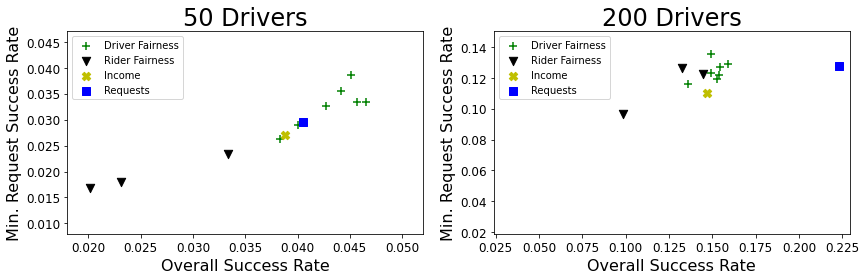

In [51]:
create_fig_1(models_dir, data_dir_orig, use_limits=True, verbose=False, plot_dir=plot_dir)

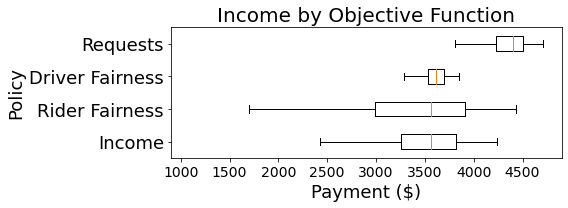

In [52]:
create_fig_2(models_dir, use_limits=True, verbose=False, plot_dir=plot_dir)

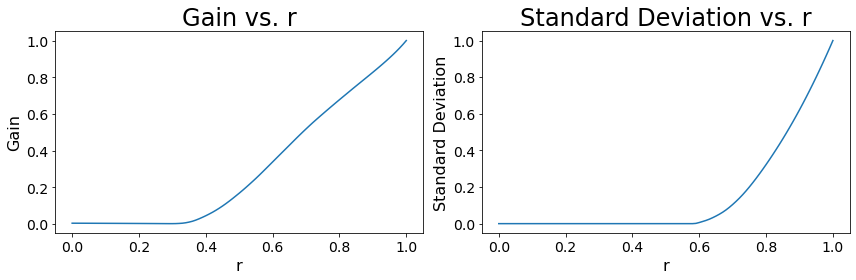

In [53]:
create_fig_3(models_dir, verbose=False, plot_dir=plot_dir)

## Run different seeds

In [54]:
varied_hyperparameters_seeding = [
    {'fairness_obj': 'requests'},
    {'fairness_obj': 'income'},
    {'fairness_obj': 'driver_fairness', 'lambda':4/6},
    {'fairness_obj': 'rider_fairness', 'lambda':10**8},
    {'fairness_obj': 'rider_fairness', 'lambda':10**9},
    {'fairness_obj': 'rider_fairness', 'lambda':10**10},
]

In [55]:
num_agents_seeding = 200

In [56]:
seeds = [490013, 423376, 191758, 688701]

In [57]:
skipped = 0
idx = 0
for part_config in varied_hyperparameters_seeding:
    for seed in seeds:
        idx += 1
        print(f'\rTraining and testing configuration {idx}/{len(varied_hyperparameters_seeding)*len(seeds)}, skipped {skipped}', end='')
        seeded_config = deepcopy(part_config)
        seeded_config['seed'] = seed
        seeded_config['num_agents'] = num_agents_seeding
        if config_exists(seeded_config, existing_configs_exp_orig):
            skipped += 1
            continue
        Settings.create_settings(model_settings_name=orig_settings_name, settings_dict=seeded_config, verbose=False)
        cur_model_dir = os.path.join(models_dir, f'{seeded_config["num_agents"]}_agents')
        train_test_configuration(data_dir_orig, cur_model_dir, embed_dir, use_tqdm=False)
print(f'\rTraining and testing configuration {idx}/{len(varied_hyperparameters_seeding)*len(seeds)}, skipped {skipped}', end='')

Training and testing configuration 24/24, skipped 24

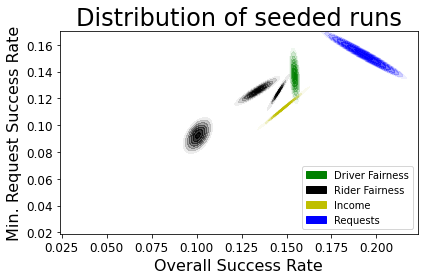

In [58]:
create_fig_1(models_dir, data_dir_orig, use_limits=True, compare_seeds=True, verbose=False, plot_dir=plot_dir)

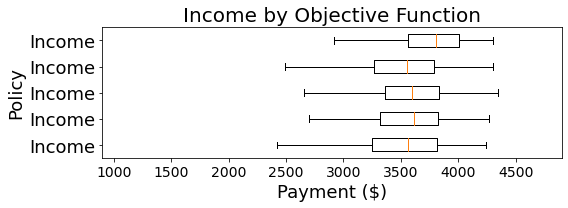

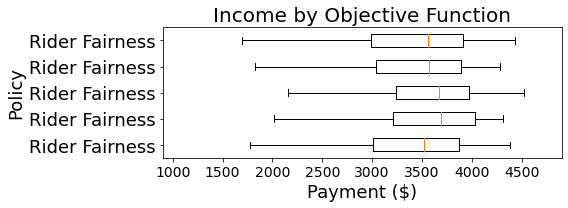

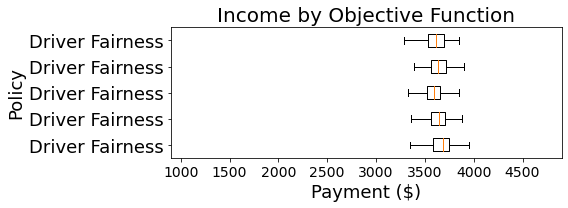

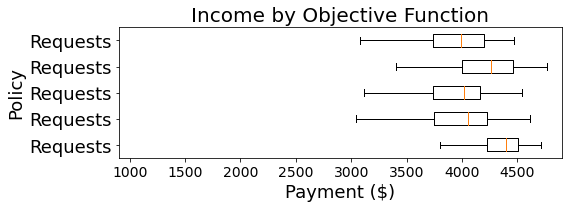

In [59]:
create_fig_2(models_dir, use_limits=True, compare_seeds=True, verbose=False, plot_dir=plot_dir)

## Demographic data analysis

In [60]:
tested_num_agents_demo = [200]

In [61]:
hyper_params_demo = []
for var_hyper_params in varied_hyperparameters:
    for num_agents in tested_num_agents_demo:
        cur_config = {'num_agents': num_agents}
        cur_config.update(var_hyper_params)
        hyper_params_demo.append(cur_config)

In [62]:
print('Number of configurations:', len(hyper_params_demo))

Number of configurations: 12


In [63]:
demo_sub_dir = 'demographic'

In [64]:
model_paths_exp_demo = get_model_paths(models_dir, sub_dirs=[demo_sub_dir])
existing_configs_exp_demo = load_test_results(model_paths_exp_demo)

Not taking into account the same runs with different seeds
nr neighbourhoods: 29
nr neighbourhoods: 29
nr neighbourhoods: 29
nr neighbourhoods: 29
nr models:  4


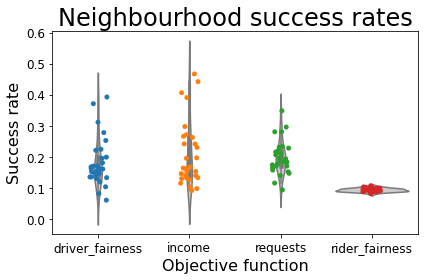

In [65]:
violin_plots_per_obj_func(['demographic'])

### Training and testing models

In [66]:
skipped = 0
for idx, part_config in enumerate(hyper_params_demo):
    print(f'\rTraining and testing configuration {idx+1}/{len(hyper_params_demo)}, skipped {skipped}', end='')
    if config_exists(part_config, existing_configs_exp_demo):
        skipped += 1
        continue
    Settings.create_settings(model_settings_name=orig_settings_name,settings_dict=part_config, verbose=False)
    cur_model_dir = os.path.join(models_dir, demo_sub_dir)
    train_test_configuration(data_dir_new_neigh, cur_model_dir, use_tqdm=False)
print(f'\rTraining and testing configuration {idx+1}/{len(hyper_params_demo)}, skipped {skipped}')

Training and testing configuration 12/12, skipped 12


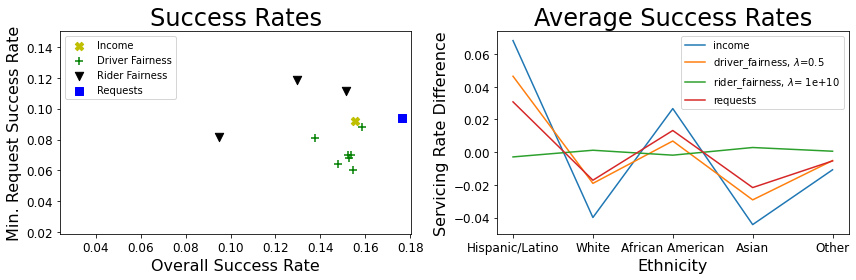

In [67]:
analyse_demographics(data_dir=data_dir_new_neigh, model_dir=models_dir, plot_dir=plot_dir)

# Examine Time

In [68]:
model_paths_all = get_model_paths(models_dir)

In [69]:
exp_totals = []
for model_path in model_paths_all:
    time_path = os.path.join(model_path, 'times.json')
    if os.path.isfile(time_path):
        with open(time_path) as f:
            cur_times = json.load(f)
        exp_totals.append(cur_times['total'])

In [71]:
embed_totals = []
for embedding_path in [embed_dir]:
    file = os.path.join(embedding_path, 'output_100.txt')
    if os.path.isfile(file):
        total_line = None
        with open(file) as f:
            lines = f.read().splitlines()
            embed_time = float(lines[-1].split()[-1][:-1])
            embed_totals.append(embed_time)

In [72]:
total = sum(exp_totals) + sum(embed_totals)   
print(f'Training and testing took {round(total/60/60)}h ({round(total/60/60/24,1)}d)')

Training and testing took 202h (8.4d)
